In [35]:
import numpy as np
import scipy
import commpy
import matplotlib.pyplot as plt
%matplotlib inline

https://dspillustrations.com/pages/posts/misc/baseband-up-and-downconversion-and-iq-modulation.html

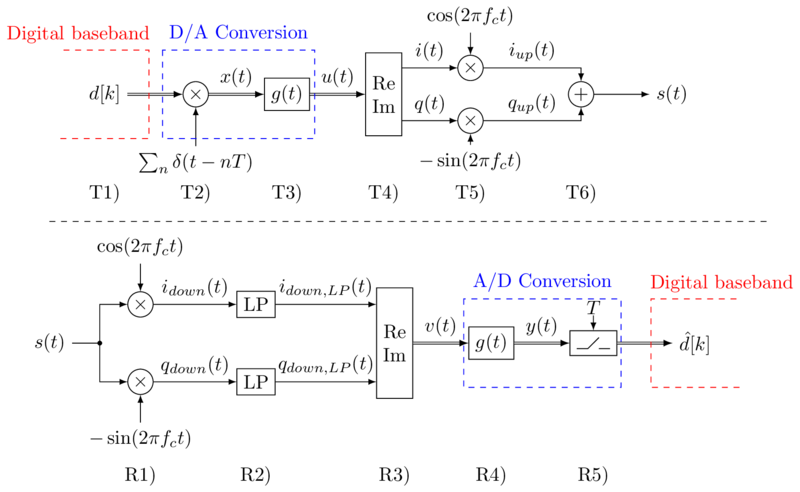

In [3]:
Fs = int(6e4)    # the sampling frequency we use for the discrete simulation of analog signals

fc = int(3e3)    # 3kHz carrier frequency
Ts = 1e-3        # 1 ms symbol spacing, i.e. the baseband samples are Ts seconds apart.
BN = 1/(2*Ts )   # the Nyquist bandwidth of the baseband signal.


ups = int(Ts*Fs) # number of samples per symbol in the "analog" domain
N = 10           # number of transmitted baseband samples

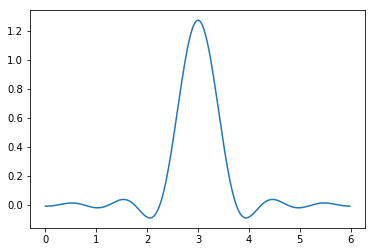

In [8]:
## Define the transmit filter
# the RRC filter should span 3 baseband samples to the left and to the right. 
# Hence, it introduces a delay of 3Ts seconds.
t0 = 3*Ts  


# Calculate the filter coefficients (N=number of samples in filter)
_, rrc = commpy.filters.rrcosfilter(N=int(2*t0*Fs), alpha=1,Ts=Ts, Fs=Fs)
t_rrc = np.arange(len(rrc)) / Fs  # the time points that correspond to the filter values
plt.plot(t_rrc/Ts, rrc)

Text(0,0.5,'d[k]')

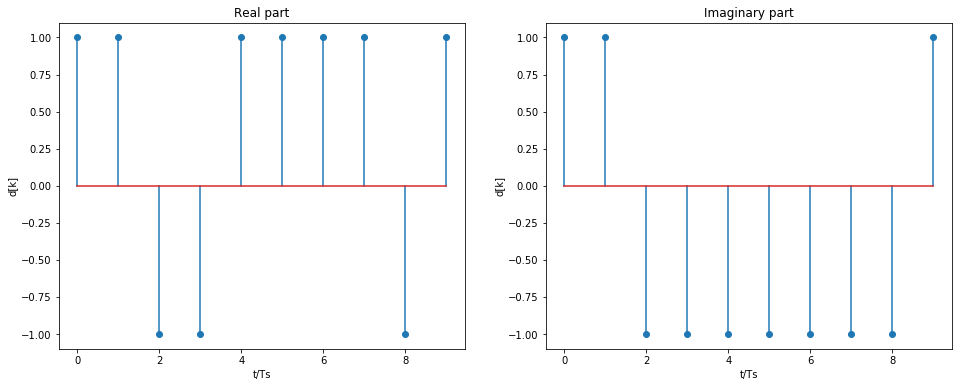

In [11]:
# Step T1)
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j])  # the possible values in the baseband
dk = np.random.choice(constellation, size=(N))        # randomly choose some samples
t_symbols = Ts * np.arange(N)                         # time instants of the baseband samples
plt.figure(figsize = (16,6))
# Plot the samples
plt.subplot(121)
plt.stem(t_symbols/Ts, dk.real);
plt.title('Real part')
plt.xlabel('t/Ts')
plt.ylabel('d[k]')
plt.subplot(122)
plt.stem(t_symbols/Ts, dk.imag);
plt.title('Imaginary part')
plt.xlabel('t/Ts')
plt.ylabel('d[k]')

Text(0,0.5,'$\\Im\\{x(t)\\}$')

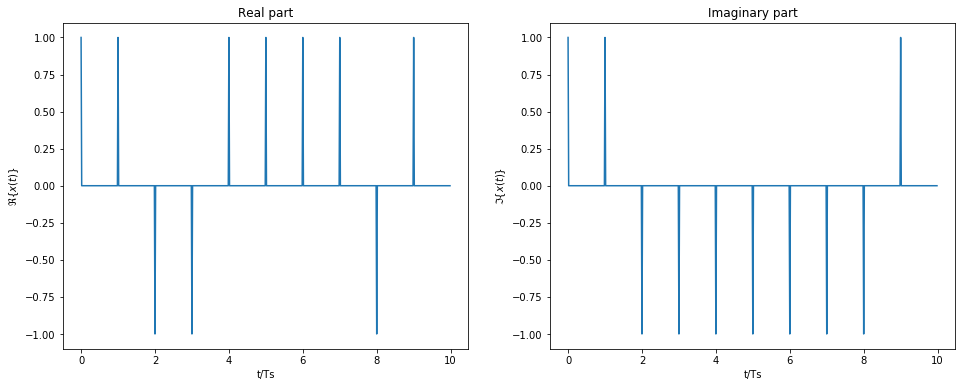

In [16]:
# Step T2)
x = np.zeros(ups*N, dtype='complex')
x[::ups] = dk  # every ups samples, the value of dn is inserted into the sequence
t_x = np.arange(len(x))/Fs

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t_x/Ts, x.real);
plt.title('Real part')
plt.xlabel('t/Ts')
plt.ylabel(r'$\Re\{x(t)\}$')
plt.subplot(122)
plt.plot(t_x/Ts, x.imag);
plt.title('Imaginary part')
plt.xlabel('t/Ts')
plt.ylabel(r'$\Im\{x(t)\}$')

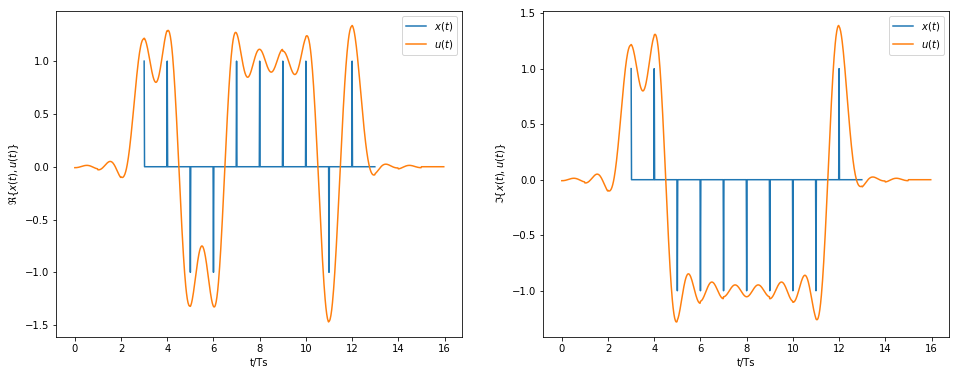

In [22]:
# Step T3)
u = np.convolve(x, rrc)

t_u = np.arange(len(u))/Fs
plt.figure(figsize = (16,6))
plt.subplot(121)  
plt.plot((t_x+t0)/Ts, x.real, label='$x(t)$') # artificial extra delay for the baseband samples
plt.plot(t_u/Ts, u.real, label='$u(t)$')
plt.xlabel('t/Ts')
plt.ylabel(r'$\Re\{x(t),u(t)\}$')
plt.legend()
plt.subplot(122)
plt.plot((t_x+t0)/Ts, x.imag,label='$x(t)$')
plt.plot(t_u/Ts, u.imag, label='$u(t)$')
plt.xlabel('t/Ts')
plt.ylabel(r'$\Im\{x(t),u(t)\}$')
plt.legend()

In [23]:
# Step T4)
i = u.real
q = u.imag

In [24]:
# Step T5)
iup = i * np.cos(2*np.pi*t_u*fc)  
qup = q * -np.sin(2*np.pi*t_u*fc)

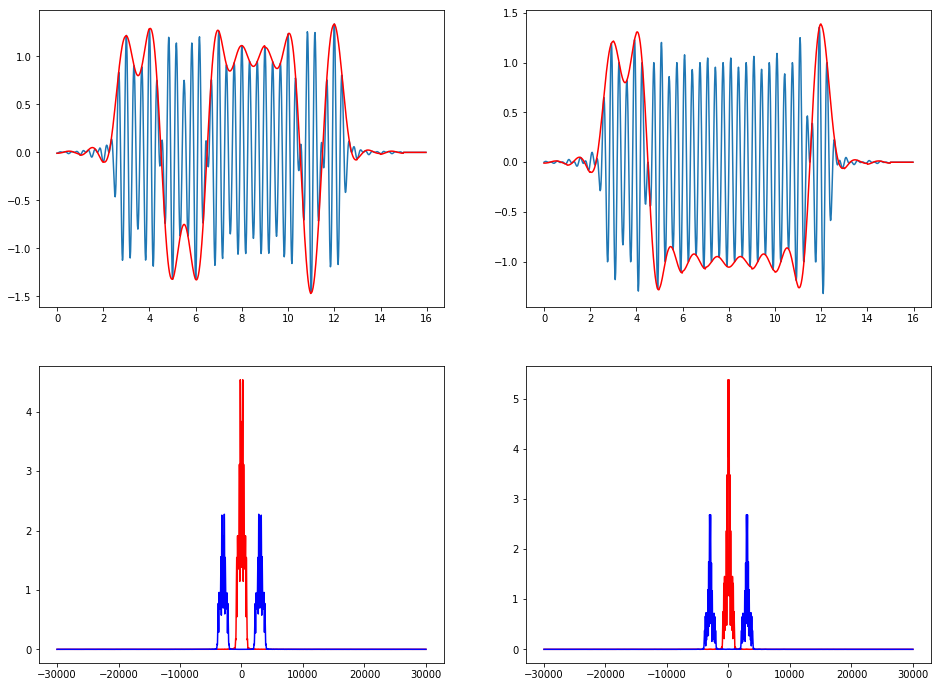

In [26]:
# define a function to calculate the spectrum of a signal
fftLen = 4*len(u)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / Fs * (len(u))

# Calculate the spectrum of the signals
f_u = np.linspace(-Fs/2, Fs/2, fftLen)
I = spectrum(i); Iup = spectrum(iup)
Q = spectrum(q); Qup = spectrum(qup)
plt.figure(figsize = (16,12))
# Plot the time-domain signals
plt.subplot(221)
plt.plot(t_u/Ts, iup, label='$i_{up}(t)$')
plt.plot(t_u/Ts, i, 'r', label='$i(t)$')

plt.subplot(222)
plt.plot(t_u/Ts, qup, label='$q_{up}(t)$')
plt.plot(t_u/Ts, q, 'r', label='$q(t)$')

plt.subplot(223)
plt.plot(f_u, abs(I), 'r')
plt.plot(f_u, abs(Iup), 'b')

plt.subplot(224)
plt.plot(f_u, abs(Q), 'r')
plt.plot(f_u, abs(Qup), 'b')

In [27]:
# Step T6)
s = iup + qup

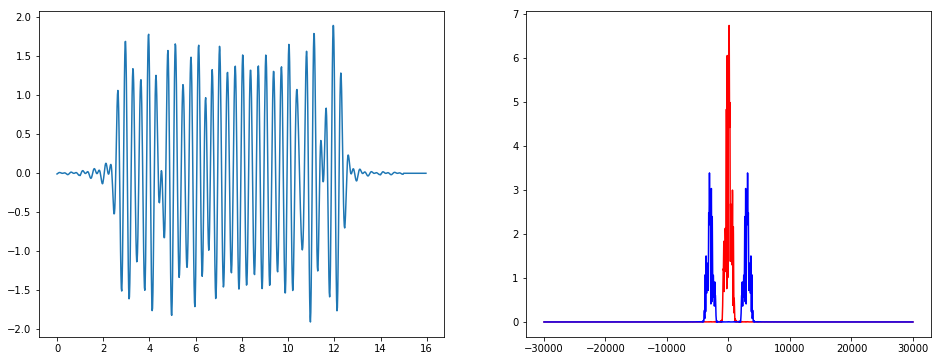

In [29]:
S = spectrum(s)
U = spectrum(u)
plt.figure(figsize = (16,6))
plt.subplot(121)
plt.plot(t_u/Ts, s)

plt.subplot(122)
plt.plot(f_u, abs(U), 'r', label='$|U(f)|$')
plt.plot(f_u, abs(S), 'b', label='$|S(f)|$')

In [30]:
# Step R1)
idown = s * np.cos(2*np.pi*-fc*t_u) 
qdown = s * -np.sin(2*np.pi*fc*t_u)

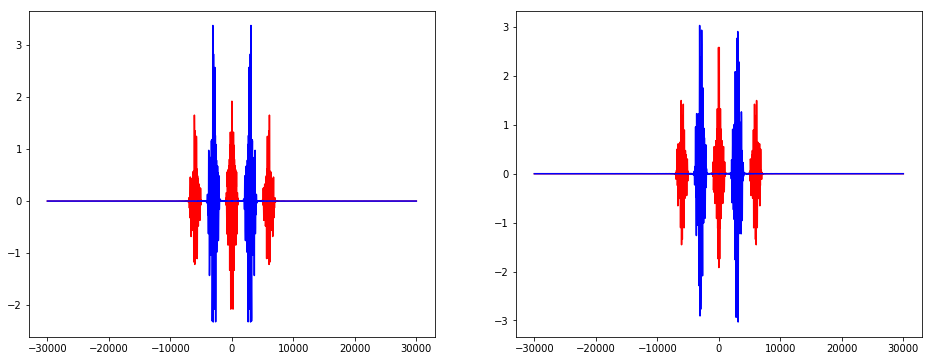

In [32]:
Idown = spectrum(idown)
Qdown = spectrum(qdown)
plt.figure(figsize = (16,6))
plt.subplot(121)
plt.plot(f_u, Idown.real, label=r'$\Re\{I_(f)\}$', color='r')
plt.plot(f_u, S.real, label='$\Re\{S(f)\}$', color='b')

plt.subplot(122)
plt.plot(f_u, Qdown.real, label=r'$\Re\{Q_(f)\}$', color='r')
plt.plot(f_u, S.imag, label=r'$\Im\{S(f)\}$', color='b')

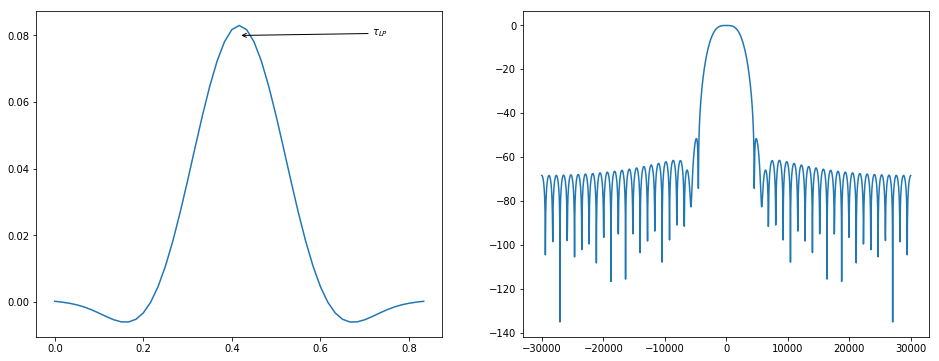

In [37]:
cutoff = 5*BN        # arbitrary design parameters
lowpass_order = 51   
lowpass_delay = (lowpass_order // 2)/Fs  # a lowpass of order N delays the signal by N/2 samples (see plot)
# design the filter
lowpass = scipy.signal.firwin(lowpass_order, cutoff/(Fs/2))

# calculate frequency response of filter
t_lp = np.arange(len(lowpass))/Fs
f_lp = np.linspace(-Fs/2, Fs/2, 2048, endpoint=False)
H = np.fft.fftshift(np.fft.fft(lowpass, 2048))
plt.figure(figsize = (16,6))
plt.subplot(121)
plt.plot(t_lp/Ts, lowpass)
plt.gca().annotate(r'$\tau_{LP}$', xy=(lowpass_delay/Ts,0.08), xytext=(lowpass_delay/Ts+0.3, 0.08), arrowprops=dict(arrowstyle='->'))

plt.subplot(122)
plt.plot(f_lp, 20*np.log10(abs(H)))

In [38]:
# Step R2) 
idown_lp = scipy.signal.lfilter(lowpass, 1, idown)
qdown_lp = scipy.signal.lfilter(lowpass, 1, qdown)

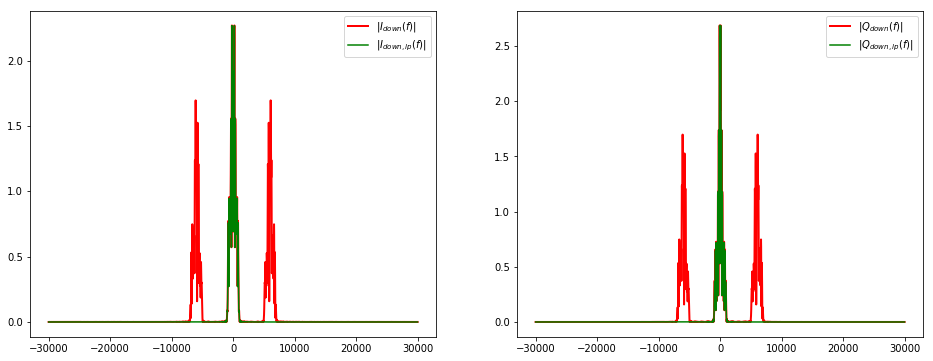

In [41]:
Idown_lp = spectrum(idown_lp)
Qdown_lp = spectrum(qdown_lp)
plt.figure(figsize = (16,6))
plt.subplot(121)
plt.plot(f_u, abs(Idown), 'r', lw=2, label=r'$|I_{down}(f)|$')
plt.plot(f_u, abs(Idown_lp), 'g-', label=r'$|I_{down,lp}(f)|$')
plt.legend()
plt.subplot(122)
plt.plot(f_u, abs(Qdown), 'r', lw=2, label=r'$|Q_{down}(f)|$')
plt.plot(f_u, abs(Qdown_lp), 'g', label=r'$|Q_{down,lp}(f)|$')
plt.legend()

In [42]:
# Step R3)
v = idown_lp + 1j*qdown_lp

In [43]:
# Step R4)
y = np.convolve(v, rrc) / (sum(rrc**2)) * 2

In [44]:
# Step R5)
delay = int((2*t0 + lowpass_delay)*Fs)

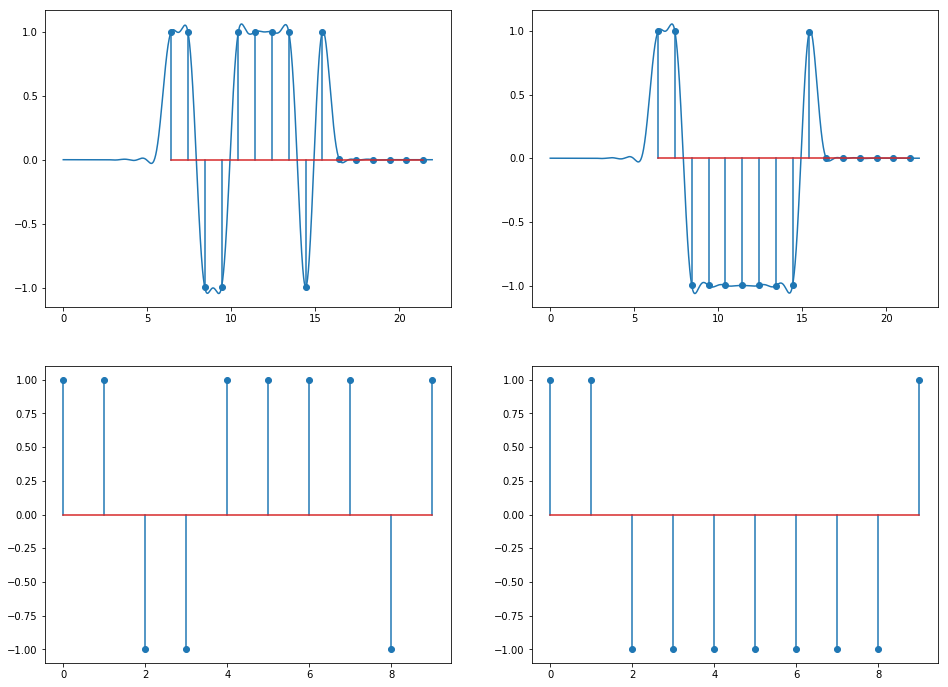

In [48]:
t_y = np.arange(len(y))/Fs
t_samples = t_y[delay::ups]
y_samples = y[delay::ups]
plt.figure(figsize = (16,12))
plt.subplot(221)
plt.plot(t_y/Ts, y.real)
plt.stem(t_samples/Ts, y_samples.real)

plt.subplot(222)
plt.plot(t_y/Ts, y.imag)
plt.stem(t_samples/Ts, y_samples.imag)

plt.subplot(223)
plt.stem(t_symbols/Ts, dk.real);
plt.subplot(224)
plt.stem(t_symbols/Ts, dk.imag);